## Problem Statement and Governing Equations

We consider the **Savage–Hutter avalanche model**, describing the motion of a finite mass of granular material sliding down a rough, inclined plane [1,2].

---

### Physical Scenario

We aim to predict:
- **Layer thickness** $h(x, t)$: The thickness of the flowing layer at position $x$ and time $t$.
- **Depth-averaged velocity** $\bar{u}(x, t)$: The mean velocity of the flow at position $x$ and time $t$.

**Key parameters:**

- $x$: Downslope coordinate (meters)
- $t$: Time (seconds)
- $\theta$: Slope angle (radians)
- $g$: Gravitational acceleration (m/s²)
- $\beta$: Internal friction parameter (active pressure coefficient)
- $\delta$: Basal friction angle (radians)
- $M$: Total mass (conserved)

---

### Governing Equations

The system is governed by two coupled partial differential equations:

#### 1. Mass Conservation (Continuity Equation)

$$
\frac{\partial h}{\partial t} + \frac{\partial}{\partial x} \left( h \, \bar{u} \right) = 0
$$

This equation ensures that mass is conserved: any change in thickness at a point is balanced by the flux of material.

---

#### 2. Momentum Conservation (Force Balance Equation)

$$
\frac{\partial \bar{u}}{\partial t}
+ \bar{u} \frac{\partial \bar{u}}{\partial x}
= \sin \theta - \beta - \tan \delta \cos \theta
- \beta \frac{\partial h}{\partial x}
$$

This equation represents the balance between gravitational driving force, internal friction, and basal (bottom) friction.

---

### Boundary and Initial Conditions

- **Initial condition** (at $t = 0$):
    - $h(x, 0)$: Parabolic profile, centered pile at rest
    - $\bar{u}(x, 0) = 0$: Initially at rest

- **Boundary condition** (for all $t$):
    - $h(x_{\text{edge}}, t) = 0$: Thickness vanishes at the leading and trailing edges of the pile

---

These equations and conditions define the mathematical framework for both the analytical solution and the PINN model implementation in this notebook.

---

**References:**

[1] Savage, S.B. & Hutter, K. (1989). "The motion of a finite mass of granular material down a rough incline." *Journal of Fluid Mechanics*, 199, 177–215.  
[2] Iverson, R.M. (1997). "The physics of debris flows." *Reviews of Geophysics*, 35(3), 245–296.



## Analytical Solution: Parabolic Cap Similarity Solution

To validate our PINN approach, we compare its predictions against the **analytical (exact) similarity solution** for this avalanche flow problem, as derived by Savage & Hutter (1989).

---

### Similarity Variable

The solution uses a **similarity variable** $\eta$, which scales the spatial coordinate $x$ relative to the moving and spreading pile:

$$
\eta = \frac{x - X_{\mathrm{mid}}(t)}{g(t)}
$$

where:
- $X_{\mathrm{mid}}(t)$: Center position of the pile at time $t$,
- $g(t)$: Half-width of the spreading pile at time $t$.

---

### Analytical Form of the Solution

The analytical solution is given by:

- **Layer thickness:**

  $$
  h(x, t) = A \left[ 1 - \left( \frac{x - X_{\mathrm{mid}}(t)}{g(t)} \right)^2 \right]
  $$

- **Depth-averaged velocity:**

  $$
  \bar{u}(x, t) = B \cdot \frac{x - X_{\mathrm{mid}}(t)}{g(t)}
  $$

where $A$ and $B$ are constants determined by the initial conditions and system parameters.

---

### Pile Spreading Dynamics

The **half-width** $g(t)$ of the pile spreads according to:

$$
g(t) \frac{d g}{d t} = K
$$

with initial condition $g(0) = 1$.  
The implicit solution for $g(t)$ is:

$$
(g - 1)\sqrt{g} + \ln\left( \sqrt{g} + \sqrt{g - 1} \right) = 2 K t
$$

where $K$ is a constant determined by the slope angle $\theta$, friction coefficients $\beta$, $\delta$, and total mass $M$.

---

### Boundary and Initial Conditions (for the analytical solution)

- $h(x, 0)$ is parabolic and centered, $u(x, 0) = 0$
- $h(\pm g(t), t) = 0$ (pile vanishes at the edges)

---

This **parabolic cap similarity solution** provides a reference to assess the accuracy of our PINN model.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Parameters
A = 1.0
Xmid = 0.0
K = 0.5

def g_t(t): return np.sqrt(1 + 2*K*t)
def analytical_h(x, t):
    g = g_t(t); eta = (x - Xmid)/g
    h = A * (1 - eta**2)
    h[np.abs(eta) > 1] = 0
    return h

# Data
x = np.linspace(-2, 2, 300)
t_vals = np.linspace(0, 1, 100)

# Plot setup
fig, ax = plt.subplots(figsize=(8,4))
line, = ax.plot([], [], lw=2)
ax.set_xlim(x.min(), x.max())
ax.set_ylim(0, A*1.1)
ax.set_xlabel('x')
ax.set_ylabel('h(x, t)')
title = ax.set_title('')

# Init + update
def init():
    line.set_data([], [])
    title.set_text('')
    return line, title

def update(i):
    t = t_vals[i]
    h = analytical_h(x, t)
    line.set_data(x, h)
    title.set_text(f't = {t:.2f}')
    return line, title

ani = FuncAnimation(fig, update, frames=len(t_vals), init_func=init,
                    blit=True, interval=50)
plt.close(fig)

# Display HTML5 video-friendly
HTML(ani.to_jshtml())


In [8]:
import torch
import torch.nn as nn
import numpy as np

# Reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cuda


In [9]:
class PINN(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim,hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim,hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim,2)  # Output: [h, u]
        )

    def forward(self, inputs):
        return self.net(inputs)

model = PINN(hidden_dim=256).to(device)
print(model)


PINN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): Tanh()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): Tanh()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): Tanh()
    (10): Linear(in_features=256, out_features=256, bias=True)
    (11): Tanh()
    (12): Linear(in_features=256, out_features=2, bias=True)
  )
)


In [10]:
## Training Data

# Defining ranges for x and t 
x_min , x_max = -1.5, 1.5
t_min, t_max = 0.0, 1.0


N_col = 20000 #Collocation points 
N_ic = 1000    #Initial Condition points 
N_bc = 1000    # Boundary condition points 

#Sample collocation points for the pdes 

x_col = torch.FloatTensor(N_col,1).uniform_(x_min, x_max).to(device).requires_grad_(True)
t_col = torch.FloatTensor(N_col,1).uniform_(t_min, t_max).to(device).requires_grad_(True)

x_ic = torch.FloatTensor(N_ic, 1).uniform_(x_min,x_max).to(device)
t_ic = torch.zeros_like(x_ic).to(device)


# Now we need to define the true initial value at these points basically at h(x,0) is a parobolic cap and u(x,0)=0

def initial_h(x):
    g0 = (x_max-x_min)/2
    Xmid = 0.0
    A = 1.0
    eta = (x-Xmid)/g0
    h = A*(1- eta**2)
    h[np.abs(eta) > 1] = 0
    return h

h_ic_true = torch.tensor(initial_h(x_ic.cpu().numpy()), dtype=torch.float32).to(device)
u_ic_true = torch.zeros_like(x_ic)



# Left edge (x=x_min), right edge (x=x_max), random times
N_each = N_bc // 2
t_left = torch.FloatTensor(N_each, 1).uniform_(t_min, t_max)
t_right = torch.FloatTensor(N_each, 1).uniform_(t_min, t_max)
x_left = torch.full((N_each, 1), x_min)
x_right = torch.full((N_each, 1), x_max)

x_bc = torch.cat([x_left, x_right], dim=0).to(device)
t_bc = torch.cat([t_left, t_right], dim=0).to(device)


In [11]:
def pde_loss(model, x_col, t_col, theta, beta, delta):
    # Combine x and t
    inputs = torch.cat([x_col, t_col], dim=1)
    #Get Model output
    out = model(inputs)
    h = out[:, 0:1]
    u = out[:, 1:2]
    
    # Continuity Equation
    h_t = torch.autograd.grad(h,t_col, grad_outputs=torch.ones_like(h), retain_graph=True, create_graph=True)[0]
    hu = h * u
    hu_x = torch.autograd.grad(hu,x_col, grad_outputs=torch.ones_like(hu), retain_graph=True, create_graph=True)[0] 
    mass_res = h_t + hu_x   #mass residual

    #Momentum Equation
    u_t = torch.autograd.grad(u, t_col, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_x = torch.autograd.grad(u, x_col, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    h_x = torch.autograd.grad(h, x_col, grad_outputs=torch.ones_like(h), retain_graph=True, create_graph=True)[0]

    #Compution RHS
    rhs = np.sin(theta) - beta - np.tan(delta)*np.cos(theta)
    mom_res = u_t + u * u_x - rhs + beta*h_x

    # returning the mean square error 
    return torch.mean(mass_res**2) + torch.mean(mom_res**2)


def ic_loss(model, x_ic, t_ic, h_ic_true, u_ic_true):
    # Combine x and t
    inputs = torch.cat([x_ic, t_ic], dim=1)
    out = model(inputs)
    h_pred = out[:, 0:1]
    u_pred = out[:, 1:2]
    # MSE between predicted and true initial values
    return torch.mean((h_pred - h_ic_true)**2) + torch.mean((u_pred - u_ic_true)**2)

def bc_loss(model, x_bc, t_bc):
    # Combine x and t
    inputs = torch.cat([x_bc, t_bc], dim=1)
    out = model(inputs)
    h_pred = out[:, 0:1]
    # Penalize nonzero h at edges
    return torch.mean(h_pred**2)

def total_loss(model, x_col, t_col, x_ic, t_ic, h_ic_true, u_ic_true, x_bc, t_bc, theta, beta, delta):
    # Physics PDE loss
    loss_pde = pde_loss(model, x_col, t_col, theta, beta, delta)
    # Initial condition loss
    loss_ic = ic_loss(model, x_ic, t_ic, h_ic_true, u_ic_true)
    # Boundary condition loss
    loss_bc = bc_loss(model, x_bc, t_bc)
    # Total loss (sum)
    return loss_pde + 10*loss_ic + 10*loss_bc



In [ ]:
# Setting physical parameters 

theta = np.radians(30)
beta = 0.2
delta = np.radians(25)

# Instantiating Optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)


#number of epochs 
num_epochs = 10000

loss_history = []

for epoch in range(num_epochs):
    optimizer.zero_grad()  # Set gradients to zero
    # Compute the total loss (PDE + IC + BC)
    loss = total_loss(
        model, x_col, t_col,
        x_ic, t_ic, h_ic_true, u_ic_true,
        x_bc, t_bc,
        theta, beta, delta
    )
    loss.backward()        # Compute gradients
    optimizer.step()       # Update model parameters
    scheduler.step()
    loss_history.append(loss.item())  # Save loss value
    
    # Print progress every 500 epochs
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

print("Training finished.")

Epoch 0, Loss: 4.827303
Epoch 500, Loss: 0.005162
Epoch 1000, Loss: 0.004423
Epoch 1500, Loss: 0.003887
Epoch 2000, Loss: 0.003429
Epoch 2500, Loss: 0.003161
Epoch 3000, Loss: 0.002968
Epoch 3500, Loss: 0.002787


In [22]:
print("x_ic device:", x_ic.device)
print("t_ic device:", t_ic.device)
print("h_ic_true device:", h_ic_true.device)
print("u_ic_true device:", u_ic_true.device)
print("model device:", next(model.parameters()).device)


x_ic device: cuda:0
t_ic device: cuda:0
h_ic_true device: cuda:0
u_ic_true device: cuda:0
model device: cuda:0


In [23]:
x_col = x_col.to(device)
t_col = t_col.to(device)
x_ic = x_ic.to(device)
t_ic = t_ic.to(device)
h_ic_true = h_ic_true.to(device)
u_ic_true = u_ic_true.to(device)
x_bc = x_bc.to(device)
t_bc = t_bc.to(device)
# This is done to put all the tensor value in the same device that is cuda 0

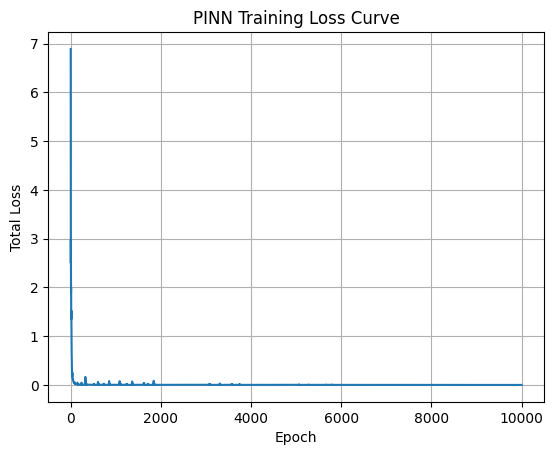

In [6]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('PINN Training Loss Curve')
plt.grid(True)
plt.show()


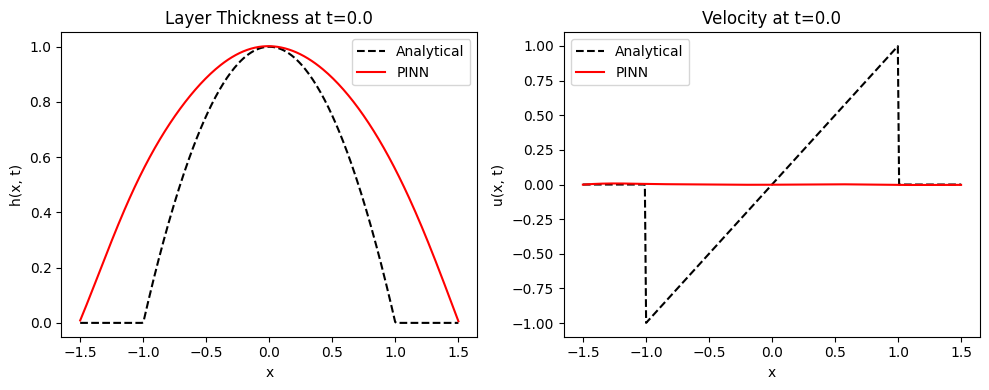

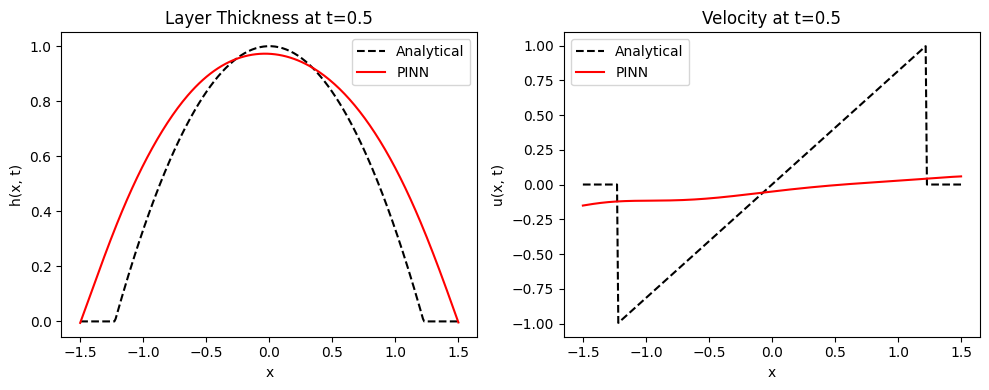

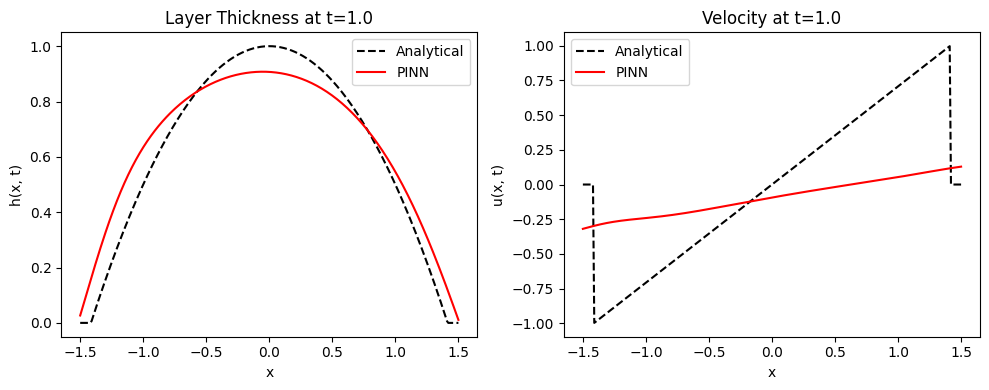

In [7]:
def g_t(t, K=0.5):
    # Example: g(t) = sqrt(1 + 2Kt)
    return np.sqrt(1 + 2*K*t)

def analytical_h(x, t, A=1.0, Xmid=0.0, K=0.5):
    g = g_t(t, K)
    eta = (x - Xmid) / g
    h = A * (1 - eta**2)
    h[np.abs(eta) > 1] = 0
    return h

def analytical_u(x, t, B=1.0, Xmid=0.0, K=0.5):
    g = g_t(t, K)
    eta = (x - Xmid) / g
    u = B * eta
    u[np.abs(eta) > 1] = 0
    return u




t_plot = [0.0, 0.5, 1.0]
x_plot = np.linspace(x_min, x_max, 300)
x_torch = torch.tensor(x_plot, dtype=torch.float32, device=device).unsqueeze(1)

for t_val in t_plot:
    t_torch = torch.full_like(x_torch, float(t_val))
    inputs = torch.cat([x_torch, t_torch], dim=1)
    with torch.no_grad():
        pred = model(inputs)
    h_pred = pred[:, 0].cpu().numpy()
    u_pred = pred[:, 1].cpu().numpy()
    
    # True analytical solution (now t-dependent!)
    h_true = analytical_h(x_plot, t_val)
    u_true = analytical_u(x_plot, t_val)
    
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(x_plot, h_true, 'k--', label='Analytical')
    plt.plot(x_plot, h_pred, 'r-', label='PINN')
    plt.xlabel('x')
    plt.ylabel('h(x, t)')
    plt.title(f'Layer Thickness at t={t_val}')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(x_plot, u_true, 'k--', label='Analytical')
    plt.plot(x_plot, u_pred, 'r-', label='PINN')
    plt.xlabel('x')
    plt.ylabel('u(x, t)')
    plt.title(f'Velocity at t={t_val}')
    plt.legend()
    plt.tight_layout()
    plt.show()
